# Employee Turnover Prediction

---

Having stable workforce is vital for organisation's success by increasing productivity, cost effectiveness and institutional knowledge. This project aims to develop Random Survival Forest (RSF) model for predicting employee turnover, identify factors that influences turnover, and suggest intervention strategies.

Our data is from [IBM HR analytics synthetic data](https://github.com/IBM/employee-attrition-aif360/), analysed using R.

---

## Performing Data Wrangling

After importing the dataset, we first skim the data and check for data types, ranges, duplicates and empty values.

In [1]:
# Importing data
rm(list = ls())
hr <- read.csv("emp_attrition.csv")

# First few rows.
head(hr)
# Number of duplicated rows
nrow(hr[duplicated(hr), ])
# Number of empty values
sum(is.na(hr))
# All column's range and type
summary(hr)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,⋯,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
,<int>,<chr>,<chr>,<int>,<chr>,<int>,<int>,<chr>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,⋯,1,80,0,8,0,1,6,4,0,5
2,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,⋯,4,80,1,10,3,3,10,7,1,7
3,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,⋯,2,80,0,7,3,3,0,0,0,0
4,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,⋯,3,80,0,8,3,3,8,7,3,0
5,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,⋯,4,80,1,6,3,3,2,2,2,2
6,32,No,Travel_Frequently,1005,Research & Development,2,2,Life Sciences,1,8,⋯,3,80,0,8,2,2,7,7,3,6


[1] 0

[1] 0

      Age         Attrition         BusinessTravel       DailyRate     
 Min.   :18.00   Length:1470        Length:1470        Min.   : 102.0  
 1st Qu.:30.00   Class :character   Class :character   1st Qu.: 465.0  
 Median :36.00   Mode  :character   Mode  :character   Median : 802.0  
 Mean   :36.92                                         Mean   : 802.5  
 3rd Qu.:43.00                                         3rd Qu.:1157.0  
 Max.   :60.00                                         Max.   :1499.0  
  Department        DistanceFromHome   Education     EducationField    
 Length:1470        Min.   : 1.000   Min.   :1.000   Length:1470       
 Class :character   1st Qu.: 2.000   1st Qu.:2.000   Class :character  
 Mode  :character   Median : 7.000   Median :3.000   Mode  :character  
                    Mean   : 9.193   Mean   :2.913                     
                    3rd Qu.:14.000   3rd Qu.:4.000                     
                    Max.   :29.000   Max.   :5.000              

There are issues that we can solve by transforming our data:

1. Some unnecessary variables for analysis, such as the one reflecting unique identification (that is, `EmployeeNumber`) and the single-valued ones (such as `EmployeeCount`).

2. All string variables are categorical, with some variables specifically binary.

We will filter `EmployeeNumber` and single-valued variables via column name list to retain original dataset, and adjust the format of categorical variables. For the purpose of clarifying survival status in R's package, we convert variable `Attrition` into Boolean type.

A separate exploration conducted by Project Creator indicates possible cross-column consistency issues, particularly from time period columns (`Age`, `TotalWorkingYears`, `Years...`) and income columns (`DailyRate`, `HourlyRate`, `MonthlyIncome`, `MonthlyRate`). These may have been accidentally introduced during the creation process of our synthetic data, and with the lack of complete data column descriptions, we are skipping cleaning this aspect for now. We are also making a mental note that time period columns may have a zero value, perhaps from a round-down of "six months or less".

## Performing Additional Cleaning

In [2]:
# Filter columns
cols <- names(hr)
cols <- cols[cols != "EmployeeNumber"]
single_value_cols <- names(hr)[sapply(hr, function (col) length(unique(col)) == 1)]
cols <- cols[!(cols %in% single_value_cols)]

# Convert column data types
cat_cols <- c("BusinessTravel", "Department", "EducationField", "JobRole")
hr[cat_cols] <- lapply(hr[cat_cols], factor)
bool_cols <- c("Attrition", "Gender", "MaritalStatus", "OverTime")
hr[bool_cols] <- lapply(hr[bool_cols], function (col) ifelse(col == "Yes", TRUE, FALSE))

head(hr[cols])

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,⋯,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
,<int>,<lgl>,<fct>,<int>,<fct>,<int>,<int>,<fct>,<int>,<lgl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,41,TRUE,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,FALSE,⋯,3,1,0,8,0,1,6,4,0,5
2,49,FALSE,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,FALSE,⋯,4,4,1,10,3,3,10,7,1,7
3,37,TRUE,Travel_Rarely,1373,Research & Development,2,2,Other,4,FALSE,⋯,3,2,0,7,3,3,0,0,0,0
4,33,FALSE,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,FALSE,⋯,3,3,0,8,3,3,8,7,3,0
5,27,FALSE,Travel_Rarely,591,Research & Development,2,1,Medical,1,FALSE,⋯,3,4,1,6,3,3,2,2,2,2
6,32,FALSE,Travel_Frequently,1005,Research & Development,2,2,Life Sciences,4,FALSE,⋯,3,3,0,8,2,2,7,7,3,6


---

## Developing Initial Random Survival Forest Model

We develop Random Survival Forest model, available from R's library `randomForestSRC`. Initially we will use all our variables as the features, sparing `YearsAtCompanies` as the survival time variable and `Attrition` as status variable. To measure model's accuracy, we use Prediction Error Curve (PEC).

We then determine the overall importance score of features to understand what contributes to an employee's turnover, and also to select features for updating our model.

[1] "Average variable importance:"
    YearsWithCurrManager                 OverTime       YearsInCurrentRole 
            5.859359e-02             5.523619e-02             3.552031e-02 
       TotalWorkingYears                      Age                 JobLevel 
            2.674972e-02             2.618860e-02             2.189981e-02 
      NumCompaniesWorked            MonthlyIncome         StockOptionLevel 
            1.923357e-02             1.763090e-02             1.233798e-02 
                 JobRole          JobSatisfaction  EnvironmentSatisfaction 
            9.568800e-03             7.408258e-03             5.793543e-03 
         WorkLifeBalance         DistanceFromHome    TrainingTimesLastYear 
            5.644470e-03             3.946187e-03             3.611468e-03 
              Department           JobInvolvement           EducationField 
            3.507073e-03             2.950850e-03             2.637485e-03 
 YearsSinceLastPromotion        PercentSalaryHike    

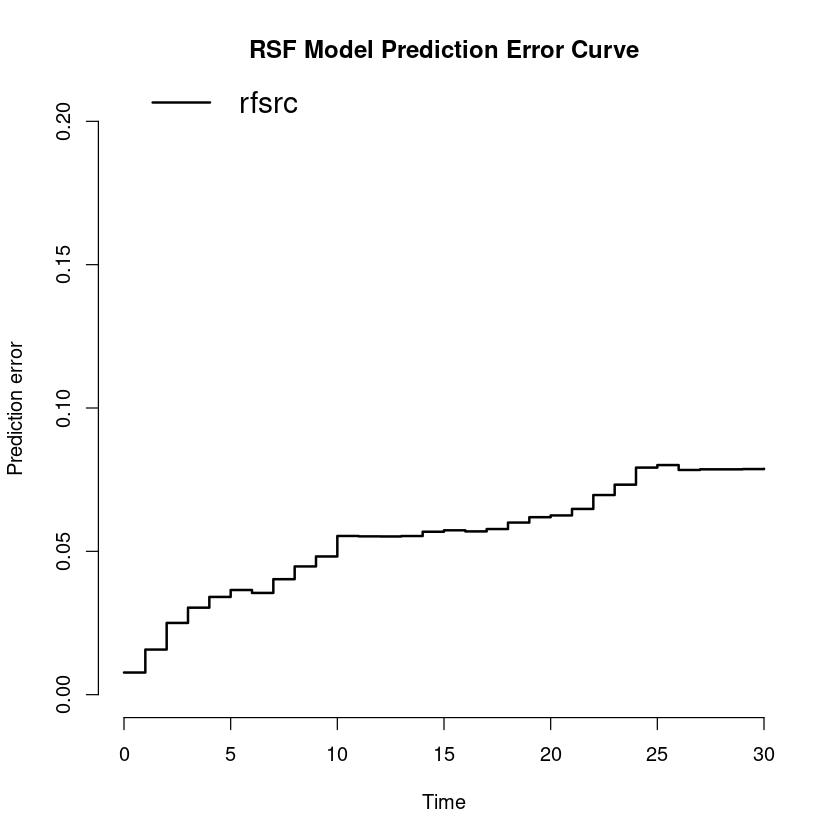

In [3]:
suppressMessages(library(randomForestSRC))
library(survival)
suppressMessages(library(pec))
library(ggplot2)
suppressMessages(library(viridis))

# Base model
rsf_model <- function (df) {
  model <- rfsrc(Surv(YearsAtCompany, Attrition) ~ ., data = df, ntree = 100)
  return(model)
}

# Accuracy plot
plot_pec <- function(df, model) {
  pred_error <- pec(model, data = df, formula = Surv(YearsAtCompany, Attrition) ~ .,
                    splitMethod = "none", cens.model = "marginal", reference = FALSE)
  plot(pred_error, xlim = c(0, 30), ylim = c(0, 0.2))
  title("RSF Model Prediction Error Curve")
}

# Importance function
rsf_importance <- function (df, model, sort = TRUE) {
  importance <- predict(model, df, importance = TRUE)$importance
  if (sort) {
      importance <- importance[order(importance, decreasing = TRUE)]
  }
  return(importance)
}

# Averaged importance rank
train_test_generate <- function (df, proportion = 0.7) {
  size <- round(proportion * nrow(df))
  idx <- sample(seq_len(nrow(df)), size = size, replace = FALSE)
  return(list("train" = df[idx, ], "test" = df[-idx, ]))
}
k_fold_cross_val <- function (df, k = 20) {
  for (fold in 1:k) {
    separate <- train_test_generate(df)
    train <- separate$train
    test <- separate$test
    model <- rsf_model(train)
    if (!(exists("importance_tot"))) {
      importance_tot <- rsf_importance(test, model, FALSE)
    } else {
      importance_tot <- importance_tot + rsf_importance(test, model, FALSE)
    }
  }
  print("Average variable importance:")
  print(importance_tot[order(importance_tot, decreasing = TRUE)]/length(importance_tot))
}

# First iteration
hr1 <- hr[cols]
model_v1 <- rsf_model(hr1)
plot_pec(hr1, model_v1)
k_fold_cross_val(hr1)

The PEC graph shows that our model has at least $92\%$ accuracy ($8\%$ error) in predicting employee stay/turnover probability.

## Refining Our Model with Feature Selection

From the importance table, temporal variables such as `Age`, `TotalWorkingYears`, `YearsWithCurrManager`, `YearsInCurrentRole` dominates the model. This is a pretty-uninspiring insight: longer work history simply implies a closer time to the future turnover event.

We remove these temporal variables from our next model features, except `Age`. Since age is a common demographic information, we are saving a feature that can be easily obtained to predict future new employees.

Meanwhile, work-welfare-related variables such as `Overtime`, `MonthlyIncome` and `StockOptionLevel` may provide more insights to employee turnover. Career-oriented features such as `JobLevel` and `NumCompaniesWorked` also appear important.

By generating correlation heatmap on the features we discussed (`OverTime`, `JobLevel`, `Age`, `NumCompaniesWorked`, `MonthlyIncome`, `StockOptionLevel`), `JobLevel` and `MonthlyIncome` are highly correlated ($> 0.7$) and thus allow us to remove one column to simplify our model. `MonthlyIncome` is retained due to clearer semantic.

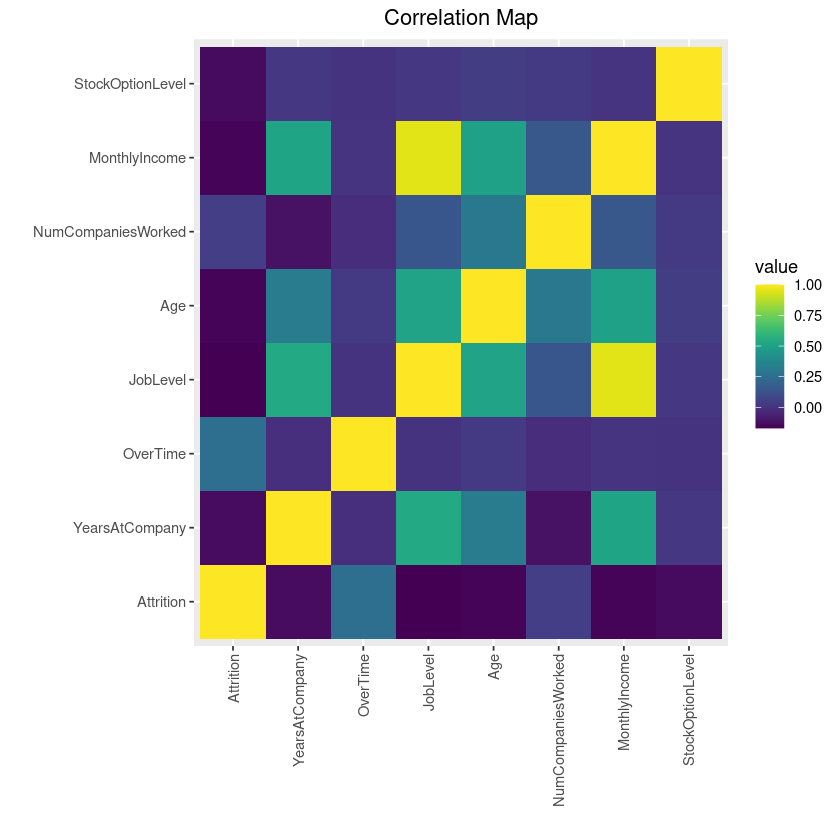

In [4]:
# Correlation
library(reshape2)

plot_correlation <- function (df, model) {
  # Only numerical (unless categories can be continuously extended)
  cor_matrix <- cor(df)
  ggplot(data = melt(cor_matrix), aes(x = Var1, y = Var2, fill = value)) +
    geom_tile() + scale_fill_viridis() +
    xlab("") + ylab("") + ggtitle("Correlation Map") +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1),
         plot.title = element_text(hjust = 0.5))
}

focus_cols <- c("Attrition", "YearsAtCompany", "OverTime", "JobLevel", "Age",
          "NumCompaniesWorked", "MonthlyIncome", "StockOptionLevel")
plot_correlation(hr[focus_cols], model_v1)

Notice that monthly income is tied to career level structure, and we want to avoid a problem where people mistook that simply increasing monthly income will result in decreased turnoever. To mitigate that, we consider `JobRole` which is moderately influential in our first model.

Furthermore, the semantics of `NumCompaniesWorked` is not clear enough to explain turnovers since it is also linked to years of working. We create and use variable `NumCompaniesWorkedPerYear` instead, indicating job-hopping. As a heuristics to prevent division by zero, we add 0.5 year to `TotalWorkingYears` when calculating this variable.

Now, we examine aggregated turnover rates based on the categorical features, just to make sure the direction of the trend, i.e. whether it is increasing or decreasing, or a more complicated form.

In [5]:
suppressMessages(library(dplyr))

aggregated_attrition <- function (df, col) {
    # Best for categorical (unless numerical int range is small)
    df[, c("Attrition", col)] %>%
      group_by_(col) %>%
      summarize(
        AttritionCount = sum(Attrition),
        TotalEmployees = n(),
        AttritionRate = AttritionCount/TotalEmployees
    )
}

options(warn = -1) # Suppress warnings

hr["NumCompaniesWorkedPerYear"] <- hr["NumCompaniesWorked"]/(hr["TotalWorkingYears"] + 0.5)

aggregated_attrition(hr, "OverTime")
aggregated_attrition(hr, "StockOptionLevel")
aggregated_attrition(hr, "JobRole")

options(warn = 0) # Reactivate warnings

OverTime,AttritionCount,TotalEmployees,AttritionRate
<lgl>,<int>,<int>,<dbl>
FALSE,110,1054,0.1043643
TRUE,127,416,0.3052885


StockOptionLevel,AttritionCount,TotalEmployees,AttritionRate
<int>,<int>,<int>,<dbl>
0,154,631,0.24405705
1,56,596,0.09395973
2,12,158,0.07594937
3,15,85,0.17647059


JobRole,AttritionCount,TotalEmployees,AttritionRate
<fct>,<int>,<int>,<dbl>
Healthcare Representative,9,131,0.06870229
Human Resources,12,52,0.23076923
Laboratory Technician,62,259,0.23938224
Manager,5,102,0.04901961
Manufacturing Director,10,145,0.06896552
Research Director,2,80,0.02500000
Research Scientist,47,292,0.16095890
Sales Executive,57,326,0.17484663
Sales Representative,33,83,0.39759036


As expected, overtime increases turnover potential. In a slightly unexpected way, no stock options and high stock options are linked to higher turnover.

Among job positions, managerial positions and Healthcare Representation have around $5\%$ attrition rate, while general positions sit at about $15-25\%$. [A simple online search](https://www.statista.com/statistics/934377/professional-services-worldwide-employee-attrition-by-region/) shows an average of $10-18\%$ global churn rate in 2022, so this company's number is comparatively a pretty high one. Sales reps roles are particularly prone to turnover (a whopping $40\%$) while also having a small number of employees. This is therefore an employee group that we need to focus on for mitigating their leaving.

## Developing Next Model

We perform previously described plan and redo our model. The PEC error shows our model is slightly improved for long-term prediction at around $94\%$ accuracy ($6\%$ error rate).

[1] "Average variable importance:"
NumCompaniesWorkedPerYear                  OverTime             MonthlyIncome 
               0.84243954                0.39651315                0.32594318 
                      Age          StockOptionLevel                   JobRole 
               0.24407085                0.12335838                0.09002648 


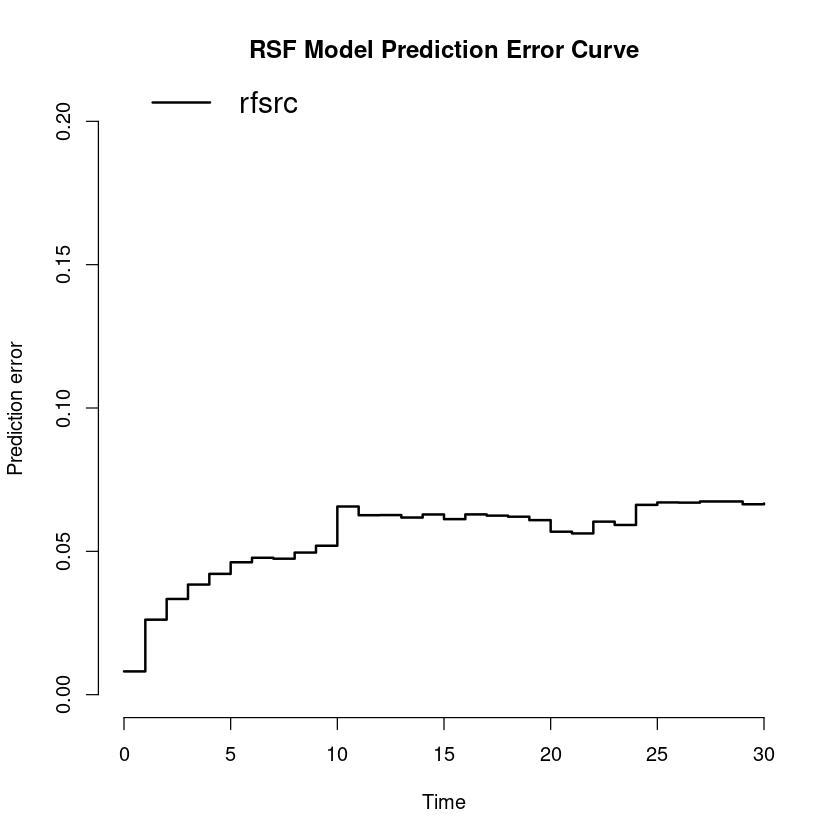

In [6]:
cols <- c("Attrition", "YearsAtCompany", "MonthlyIncome", "OverTime", "Age",
          "JobRole", "NumCompaniesWorkedPerYear", "StockOptionLevel")
hr2 <- hr[cols]
k_fold_cross_val(hr2)
model_v2 <- rsf_model(hr2)
plot_pec(hr2, model_v2)

---

## Predicting Employee Turnover Result

We create the prediction of turnover probability of our employees in the next five years. We also identify 100 individuals at risk of leaving their jobs, ignoring the ones with positive turnover already. Some turnovers give probability higher than one, which is one of current model's limitations.

In [7]:
# Where do you see yourself in the next five years?
rsf_turnover_probability <- function (df, model) {
  return(predict(model, df)$chf)
}

for (i in 1:5) {
    hr[, paste0("AttritionProb_Year", i)] <- rsf_turnover_probability(hr, model_v2)[, i+1]
}
head(hr)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,⋯,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,NumCompaniesWorkedPerYear,AttritionProb_Year1,AttritionProb_Year2,AttritionProb_Year3,AttritionProb_Year4,AttritionProb_Year5
,<int>,<lgl>,<fct>,<int>,<fct>,<int>,<int>,<fct>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,41,TRUE,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,⋯,6,4,0,5,0.9411765,0.08695400,0.24630849,0.33473094,0.364027027,0.602080055
2,49,FALSE,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,⋯,10,7,1,7,0.0952381,0.00040000,0.00040000,0.00040000,0.004173873,0.004650064
3,37,TRUE,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,⋯,0,0,0,0,0.8000000,0.43105822,0.71789215,0.95577408,1.131229260,1.525717356
4,33,FALSE,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,⋯,8,7,3,0,0.1176471,0.03407888,0.04075477,0.09829688,0.133205021,0.193267058
5,27,FALSE,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,⋯,2,2,2,2,1.3846154,0.07916466,0.20208957,0.28643132,0.486151346,0.559520394
6,32,FALSE,Travel_Frequently,1005,Research & Development,2,2,Life Sciences,1,8,⋯,7,7,3,6,0.0000000,0.01360820,0.01572934,0.03829966,0.055822818,0.108740900


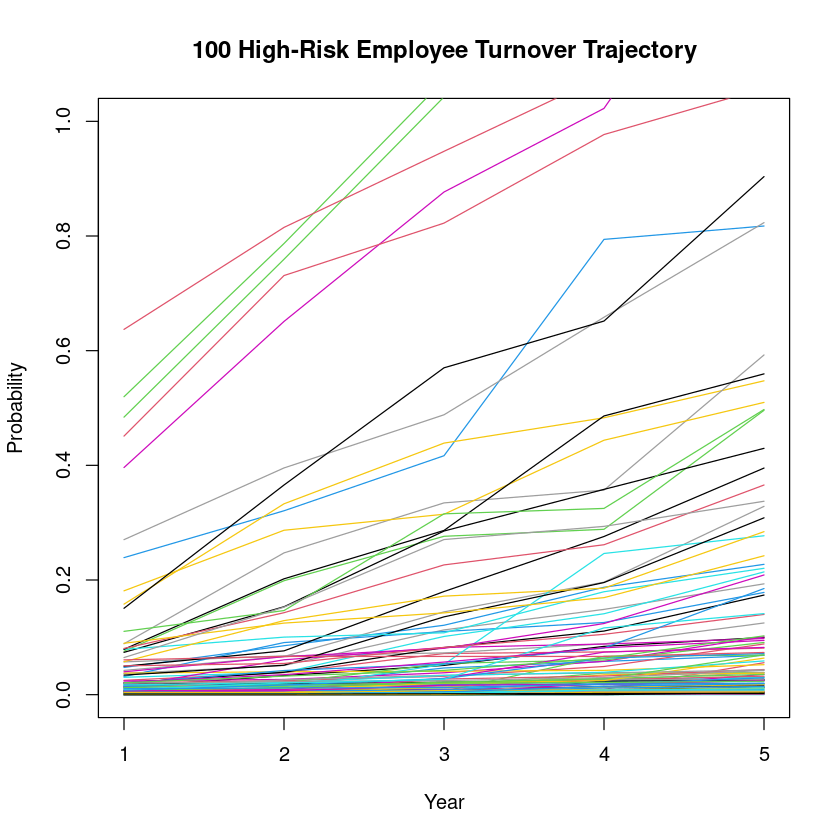

In [8]:
# Top individuals
rsf_high_risk_indiv_idx <- function (df, model, limit = 100) {
  df$HazardScore <- predict(model, df)$predicted
  return(order(df$HazardScore, decreasing = TRUE)[1:limit])
}

hriidx <- rsf_high_risk_indiv_idx(hr[hr["Attrition"] == FALSE, ], model_v2)
hrindv <- hr[hriidx, c("AttritionProb_Year1", "AttritionProb_Year2", "AttritionProb_Year3",
                                             "AttritionProb_Year4", "AttritionProb_Year5")]
plot(1, type = "n", xlim = c(1, ncol(hrindv)), ylim = c(0, 1), xlab = "Year", ylab = "Probability")
title("100 High-Risk Employee Turnover Trajectory")
for (i in 1:nrow(hrindv)) {
  lines(1:ncol(hrindv), hrindv[i, ], col = i, type = "l")
}
#legend("topright", legend = hr_emp_ids[hriidx, ], col = 1:nrow(hrindv), lty = 1, title = "EmpID")

## Recommended strategies


### Overtime Management

Excessive overtime can lead to burnout among employees. Implement strategies to manage and reduce overtime, such as workload distribution, hiring additional staff, or arranging flexible work arrangements.

### Salary and Compensation Adjustment

Consider reviewing and maybe adjusting the salary structure to make sure it is competitive within the industry and region. Competitive salary system can help attract and retain talented employees.

### High Turnover History Analysis

Understand the reasons behind high turnover among employees with a history of working at multiple companies.

### Stock Option Incentives & Communication

Consider expanding the stock option program to make it more attractive to employees. Make sure to communicate clearly to employees how the stock system works and their benefits.

### Retention Programs for Sales Reps

Our sales representatives are more prone to attrition. Implement retention programs specific to this group, such as performance-based incentives, career development paths, and mentorship programs.